## 1. 데이터 준비

In [138]:
%pip install influxdb_client

Note: you may need to restart the kernel to use updated packages.


In [139]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import zscore
from datetime import datetime, timedelta
from influxdb_client import InfluxDBClient

# 한글 폰트 설정
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False

## Influx DB 연결 정보 및 장비 위치 매핑
InfluxDB에 대한 연결 매개변수를 설정하고 장치 ID를 해당 위치에 매핑하여 데이터 검색을 구성합니다.

In [140]:
# InfluxDB 설정 정보
url = "http://133.186.144.22:8086"
token = "BPJ1pnKvoaov4Tte971t0zpRSTUXNZvrshU7u3UPheAIsBeUJEFfbKjfsZjtwZmugkHJEGRW17lH4bR9ybanNQ=="
org = "smoothing"

# 디바이스 ID와 위치를 매핑
location_mapping = {
    '24e124126d152919': 'indoor',
    '24e124126d152969': 'bottom_right_corner',
    '24e124128c067999': 'indoor',
    '24e124785c389818': 'bottom_left_corner',
    '24e124785c421885': 'top_right_corner'
}

## 데이터 가져오기
사전에 정의된 쿼리를 사용하여 InfluxDB에서 데이터를 검색합니다.

검색된 데이터는 Time, Value, Place, Location 컬럼을 포함하는 형태로 Pandas DataFrame에 저장됩니다.
 
이 데이터는 전력 데이터와 온도 데이터를 포함하며, 이를 기반으로 데이터 분석을 진행할 예정입니다.

In [141]:
# InfluxDB 클라이언트 생성
def create_client(url, token, org):
    return InfluxDBClient(url=url, token=token, org=org)

# 쿼리 실행 및 DataFrame으로 변환
def query_to_dataframe(client, query):
    result = client.query_api().query(query=query)
    results = []
    
    for table in result:
        for record in table.records:
            results.append({
                "time": record.get_time(),
                "value": record.get_value(),
                "place": record.values.get("place"),
                "location": record.values.get("location"),
                "device": record.values.get("device")
            })
    
    df = pd.DataFrame(results)
    df['time'] = df['time'].astype(str).str.replace(r'\+00:00$', '', regex=True)
    return df

# 데이터를 날짜를 지정하여 CSV 파일로 저장
def save_csv(df, file_pattern, directory):
    # 경로가 존재하는지 확인하고, 없다면 생성
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    current_date = datetime.now()
    previous_date = current_date - timedelta(days=1)
    filename = f"{directory}{previous_date.strftime(file_pattern)}"
    df.to_csv(filename, index=False)
    
# 온도 Data에서 'device' 열에 따라 'location' 열을 업데이트    
def update_location(df, location_mapping):
    df['location'] = df['device'].map(location_mapping)
    return df

### 데이터 조회 및 CSV 변환 수행

In [142]:
# 클라이언트 생성 및 쿼리 실행
client = create_client(url, token, org)

# 전력 조회 Flux 쿼리
query_power_data = '''
import "date"
from(bucket: "powermetrics_data")
  |> range(start: date.sub(d: 1d, from: date.truncate(t: now(), unit: 1d)), stop: date.truncate(t: now(), unit: 1d))
  |> filter(fn: (r) => r["phase"] == "total")
  |> filter(fn: (r) => r["description"] == "w")
  |> filter(fn: (r) => r["place"] == "class_a" or r["place"] == "office")
  |> filter(fn: (r) => r["location"] != "main")
  |> aggregateWindow(every: 2m, fn: mean, createEmpty: false)
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# CSV 변환
df_power = query_to_dataframe(client, query_power_data)
print(df_power.head())
save_csv(df_power, "%m_%d_power_data.csv", "power/")


# 온도 조회 Flux 쿼리
query_temperature_data = '''
import "date"
from(bucket: "environmentalsensors_data")
  |> range(start: date.sub(d: 1d, from: date.truncate(t: now(), unit: 1d)), stop: date.truncate(t: now(), unit: 1d))
  |> filter(fn: (r) => r["measurement"] == "temperature")
  |> filter(fn: (r) => r["place"] == "class_a" or r["place"] == "office")
  |> aggregateWindow(every: 2m, fn: mean, createEmpty: false)
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# CSV 변환
df_temperature = query_to_dataframe(client, query_temperature_data)
df_temperature_fix = update_location(df_temperature, location_mapping)
print(df_temperature_fix.head())
save_csv(df_temperature_fix, "%m_%d_temperature_data.csv", "temperature/")

# 이산화탄소 조회 Flux 쿼리
query_co2_data = '''
import "date"
from(bucket: "environmentalsensors_data")
  |> range(start: date.sub(d: 1d, from: date.truncate(t: now(), unit: 1d)), stop: date.truncate(t: now(), unit: 1d))
  |> filter(fn: (r) => r["place"] == "class_a")
  |> filter(fn: (r) => r["measurement"] == "co2")
  |> aggregateWindow(every: 2m, fn: mean, createEmpty: false)
  |> keep(columns: ["_time", "_value", "place", "location", "device"])
'''

# CSV 변환
df_co2 = query_to_dataframe(client, query_co2_data)
df_co2_fix = update_location(df_co2, location_mapping)
print(df_co2_fix.head())
save_csv(df_co2_fix, "%m_%d_co2_data.csv", "co2/")

# 클라이언트 종료
client.close()

                  time  value   place   location     device
0  2024-04-29 00:02:00   19.0  office  a_project  gems-3500
1  2024-04-29 00:04:00   20.0  office  a_project  gems-3500
2  2024-04-29 00:06:00   21.0  office  a_project  gems-3500
3  2024-04-29 00:08:00   20.0  office  a_project  gems-3500
4  2024-04-29 00:10:00   19.0  office  a_project  gems-3500
                  time  value   place location            device
0  2024-04-29 00:02:00   22.5  office   indoor  24e124126d152919
1  2024-04-29 00:04:00   22.6  office   indoor  24e124126d152919
2  2024-04-29 00:06:00   22.5  office   indoor  24e124126d152919
3  2024-04-29 00:08:00   22.6  office   indoor  24e124126d152919
4  2024-04-29 00:10:00   22.5  office   indoor  24e124126d152919
                  time  value    place location            device
0  2024-04-29 00:02:00  604.0  class_a   indoor  24e124128c067999
1  2024-04-29 00:04:00  632.0  class_a   indoor  24e124128c067999
2  2024-04-29 00:06:00  678.5  class_a   indoor  24e

# 2. 데이터 전처리
수집된 데이터를 하나의 데이터셋으로 병합합니다.

이후 데이터의 빈 값을 확인하고 제거하여 결측치를 처리합니다. 

이 과정은 데이터 분석의 정확성을 보장하고 신뢰할 수 있는 결과를 얻기 위한 중요한 단계입니다.

### 전체 데이터 병합 및 결측치 처리

In [143]:
# 전체 데이터 병합
def merge_data(directory_path):
    # 디렉토리 내의 모든 CSV 파일 목록을 생성
    csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

    # 모든 CSV 파일을 데이터 프레임으로 읽어와 하나로 병합
    data_frames = []
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        df = pd.read_csv(file_path)
        df['time'] = pd.to_datetime(df['time'])
        data_frames.append(df)

    # 모든 데이터 프레임을 하나로 병합
    merged_df = pd.concat(data_frames, ignore_index=True)

    # 원하는 컬럼만 선택
    columns_to_keep = ['time', 'value', 'place', 'location']
    filtered_df = merged_df[columns_to_keep]

    # 'place', 'time'으로 정렬
    sorted_df = filtered_df.sort_values(['place', 'time'])

    return sorted_df

# 결측치 확인 및 처리
def load_and_clean_data(df, output_directory_path, file_name):
    # 요약 사전 초기화
    file_summary = {}

    # 데이터프레임의 초기 형태 저장
    initial_shape = df.shape

    # 정리 전 총 결측치 수 계산
    missing_before = df.isnull().sum().sum()

    # 결측치 제거
    df.dropna(inplace=True)

    # 정리 후 결측치가 제거되었는지 확인하기 위해 결측치 수 다시 계산
    missing_after = df.isnull().sum().sum()

    # 요약 사전 업데이트
    file_summary["file"] = file_name
    file_summary["initial_rows"] = initial_shape[0]
    file_summary["final_rows"] = df.shape[0]
    file_summary["missing_removed"] = missing_before - missing_after

    # 출력 디렉토리가 존재하지 않는 경우 생성
    if not os.path.exists(output_directory_path):
        os.makedirs(output_directory_path)

    # 출력 파일 경로 구성
    output_file_path = os.path.join(output_directory_path, f"{file_name}_cleaned.csv")

    # 정리된 데이터프레임을 CSV로 저장
    df.to_csv(output_file_path, index=False)

    # 처리 결과 요약 출력
    print(f"파일 이름: {file_summary['file']}, 초기 행 수: {file_summary['initial_rows']}, 최종 행 수: {file_summary['final_rows']}, 제거된 결측치 수: {file_summary['missing_removed']}")

### 각 데이터 병합 및 결측치 처리 수행

In [166]:
power_path = 'power'
stats_values_df = merge_data(power_path)
load_and_clean_data(stats_values_df, "cleaned_data/power/", "power_stats")
print(stats_values_df.head(2), "\n")

temperature_path = 'temperature'
stats_values_df = merge_data(temperature_path)
load_and_clean_data(stats_values_df, "cleaned_data/temperature/", "temperature_stats")
print(stats_values_df.head(2), "\n")

co2_path = 'co2'
stats_values_df = merge_data(co2_path)
load_and_clean_data(stats_values_df, "cleaned_data/co2/", "co2_stats")
print(stats_values_df.head(2), "\n")

파일 이름: power_stats, 초기 행 수: 291216, 최종 행 수: 291216, 제거된 결측치 수: 0
                     time  value    place         location
59760 2024-04-15 00:02:00   23.5  class_a   ac_indoor_unit
61200 2024-04-15 00:02:00  112.5  class_a  ac_outdoor_unit 

파일 이름: temperature_stats, 초기 행 수: 43918, 최종 행 수: 43918, 제거된 결측치 수: 0
                     time  value    place             location
29689 2024-04-15 00:02:00  23.10  class_a  bottom_right_corner
30395 2024-04-15 00:02:00  23.85  class_a               indoor 

파일 이름: co2_stats, 초기 행 수: 9351, 최종 행 수: 9351, 제거된 결측치 수: 0
                    time  value    place location
7191 2024-04-17 00:02:00  577.5  class_a   indoor
7192 2024-04-17 00:04:00  606.0  class_a   indoor 



### 데이터 시각화
전력 사용량이 가장 큰 5개의 장비를 시각화하고, 장소별 온도 변화를 파악하기 위해 아래와 같이 시각화 하였습니다.

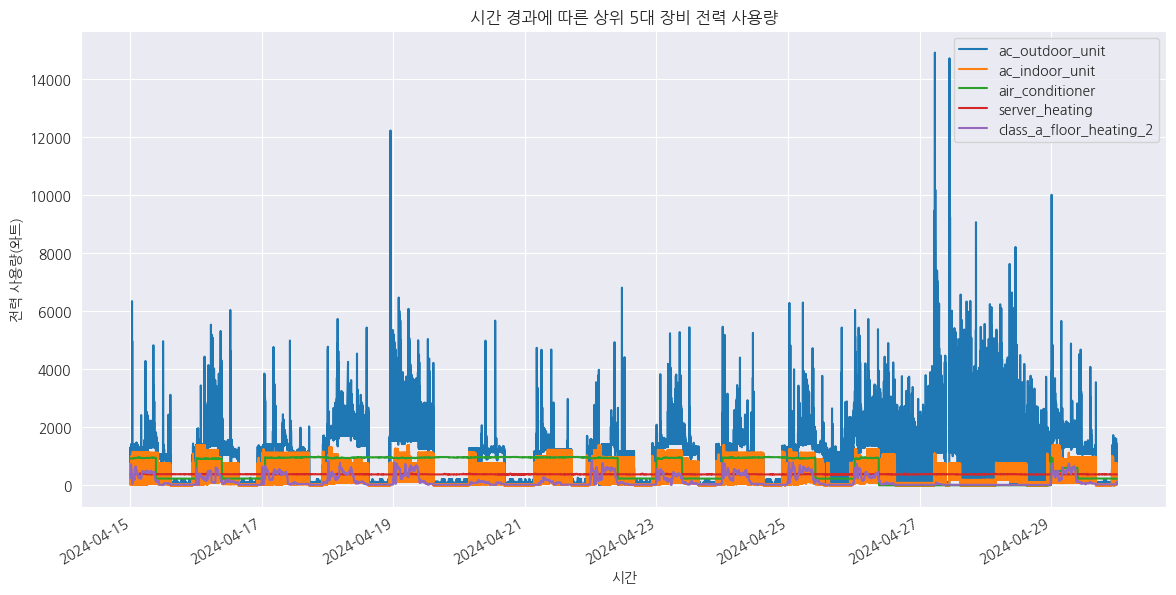

In [168]:
# 전력 사용량 데이터와 환경 센서 데이터를 로드합니다.
power_df = pd.read_csv('cleaned_data/power/power_stats_cleaned.csv')

# 'time' 열을 datetime 객체로 변환하고 인덱스로 설정합니다.
power_df['time'] = pd.to_datetime(power_df['time'])
power_df.set_index('time', inplace=True)

# 각 위치에 따른 전력 사용량의 총합 계산
total_power_per_location = power_df.groupby('location')['value'].sum()

# 전력 사용량이 가장 높은 상위 5개 위치 선정
top_locations = total_power_per_location.nlargest(5).index

# 상위 5개 장비의 시간에 따른 전력 사용량 그래프 그리기
plt.figure(figsize=(14, 7))
for location in top_locations:
    subset = power_df[power_df['location'] == location]
    subset['value'].plot(label=location)

plt.title('시간 경과에 따른 상위 5대 장비 전력 사용량')
plt.xlabel('시간')
plt.ylabel('전력 사용량(와트)')
plt.legend()
plt.grid(True)
plt.show()

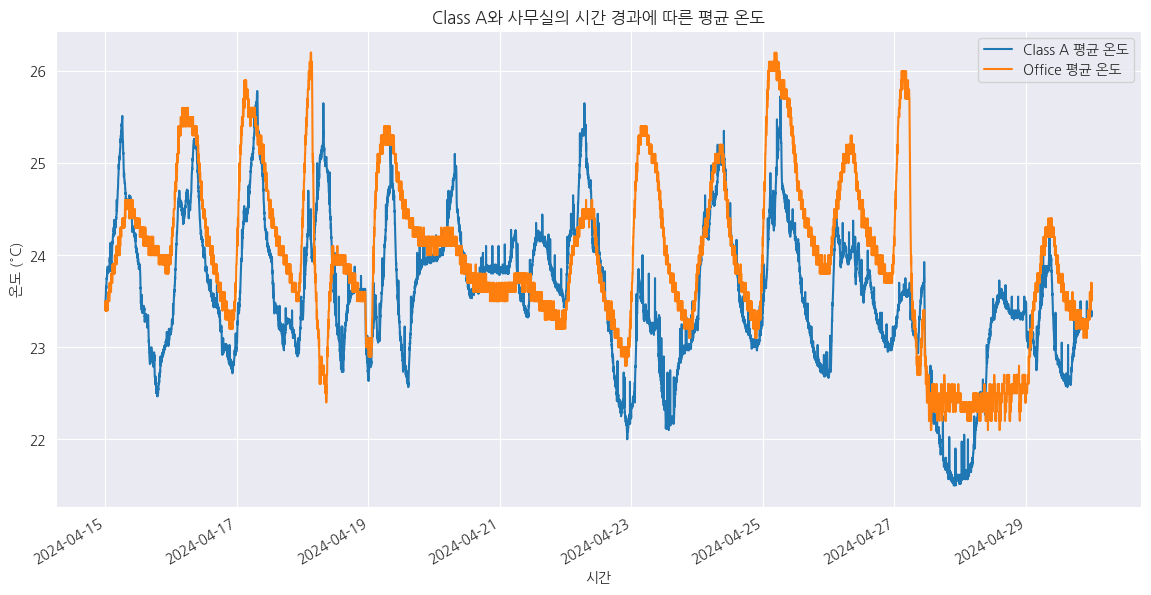

In [175]:
temperature_df = pd.read_csv('cleaned_data/temperature/temperature_stats_cleaned.csv')

# 'time' 열을 datetime 객체로 변환하고 인덱스로 설정합니다.
temperature_df['time'] = pd.to_datetime(temperature_df['time'])
temperature_df.set_index('time', inplace=True)

# 'class_a'와 'office' 데이터 필터링
filtered_data = temperature_df[temperature_df['place'].isin(['class_a', 'office'])]

# 'class_a'와 'office'의 시간별 평균 온도 계산
average_temperature_class_a = filtered_data[filtered_data['place'] == 'class_a'].groupby('time')['value'].mean()
average_temperature_office = filtered_data[filtered_data['place'] == 'office'].groupby('time')['value'].mean()

# 평균 온도 시각화
plt.figure(figsize=(14, 7))
average_temperature_class_a.plot(label='Class A 평균 온도')
average_temperature_office.plot(label='Office 평균 온도')

plt.title('Class A와 사무실의 시간 경과에 따른 평균 온도')
plt.xlabel('시간')
plt.ylabel('온도 (°C)')
plt.legend()
plt.grid(True)
plt.show()

## 전력, 온도 데이터의 연관 관계 측정
전력 사용량과 온도의 연관성을 분석하기 위해, 전력 사용량이 많을수록 온도가 높아진다는 가설을 기반으로 이에 대한 근거를 찾아보았습니다.

각 장비별 평균 전력 사용량과 평균 온도를 시간대별로 상관 관계를 분석했습니다.

### 로그 스케일 적용
로그스케일(log scale)을 사용하는 주된 이유는 현재 전력 데이터 일부의 크기가 커서 

일부 작은 값들이 상대적으로 무시되는 문제가 있습니다.

로그 스케일을 사용하면 데이터의 범위를 줄여서 작은 값들도 시각화하여

이를 효과적으로 분석하고 시각화 할 수 있습니다.

In [253]:
# 데이터 로드
power_df = pd.read_csv('cleaned_data/power/power_stats_cleaned.csv')
temperature_df = pd.read_csv('cleaned_data/temperature/temperature_stats_cleaned.csv')

# 로그 스케일을 적용합니다.
power_df['value'] = np.log1p(power_df['value'])
temperature_df['value'] = np.log1p(temperature_df['value'])

# 시간대별로 그룹화하여 각 시간대의 평균 전력 사용량을 계산합니다.
power_usage = power_df.groupby('time').value.sum().reset_index(name='power_usage')

# 시간대별로 그룹화하여 각 시간대의 평균 온도를 계산합니다.
temp_avg = temperature_df.groupby('time').value.mean().reset_index(name='avg_temperature')

# 두 데이터프레임을 시간대(time)를 기준으로 결합합니다.
combined_data = pd.merge(power_avg, temp_avg, on='time')

# 상관관계 계산
correlation = combined_data[['avg_power_usage', 'avg_temperature']].corr()

# 상관관계 출력
print(correlation)

                 avg_power_usage  avg_temperature
avg_power_usage         1.000000         0.542564
avg_temperature         0.542564         1.000000


## 전력, 온도 데이터의 연관 관계 측정2
간단한 집계로 연관 관계 수치를 보았을 때 어느 정도의 연관성이 있음을 확인할 수 있었습니다.

좀더 상세한 연관성을 확인하기 위해, 이상치 처리와 추가 전처리를 진행하였습니다.

### 이상치 시각화
이상치를 먼저 시각적으로 먼저 존재 유무를 판단후 

어떠한 방법을 사용하여 이상치를 처리할지 결정합니다.

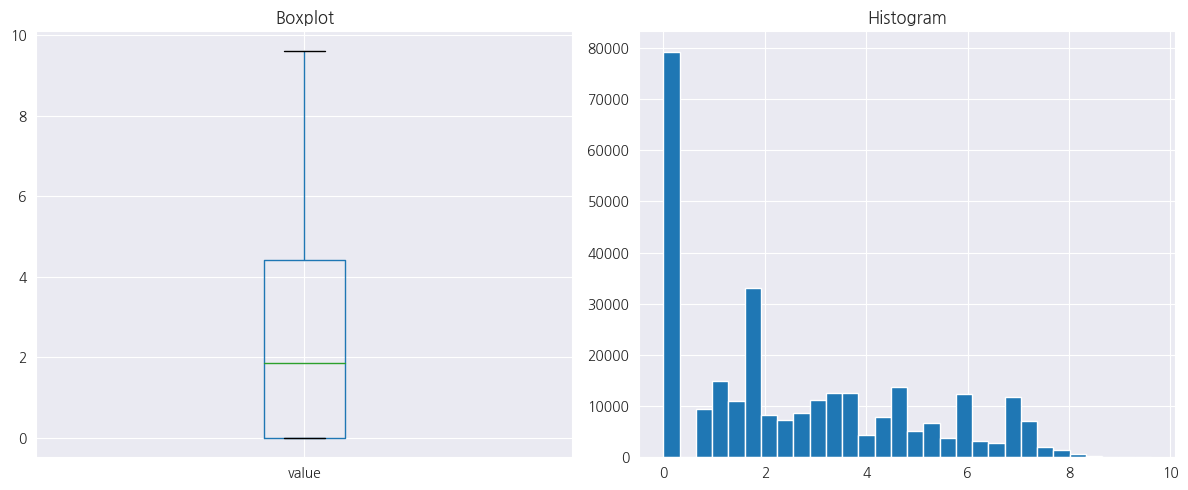

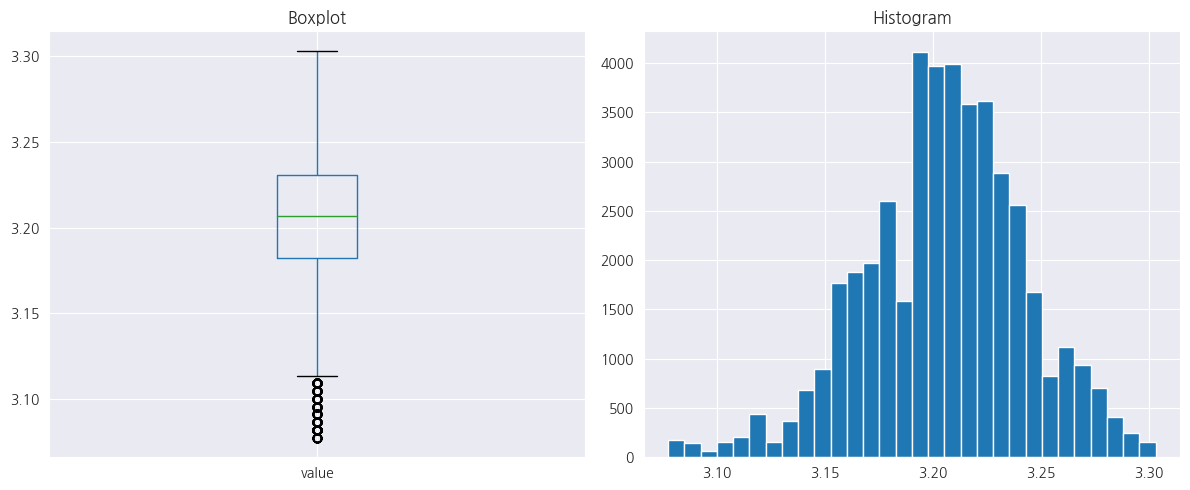

In [232]:
 # 박스 플롯과 히스토그램 그리기
def load_and_visualize_data(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    df.boxplot(column='value', ax=axes[0])
    df.hist(column='value', bins=30, ax=axes[1])

    # 플롯 제목 설정
    axes[0].set_title('Boxplot')
    axes[1].set_title('Histogram')

    plt.tight_layout()
    plt.show()

load_and_visualize_data(power_df)
load_and_visualize_data(temperature_df)

### IQR를 사용하여 이상치를 제거한 결과

온도와 전력 사용 사이의 상관계수는 다음과 같습니다:
                 avg_power_usage  avg_temperature
avg_power_usage         1.000000         0.556743
avg_temperature         0.556743         1.000000


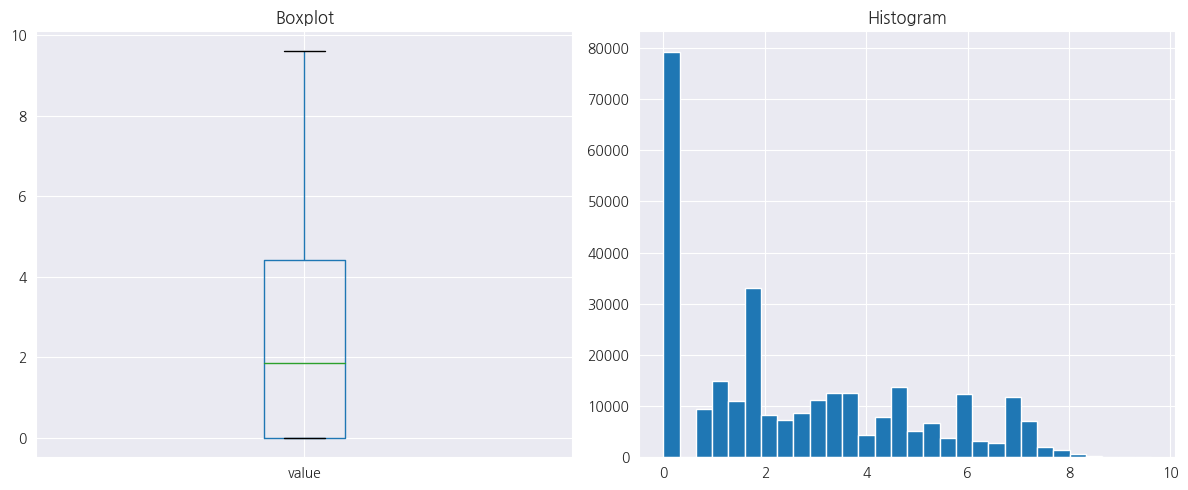

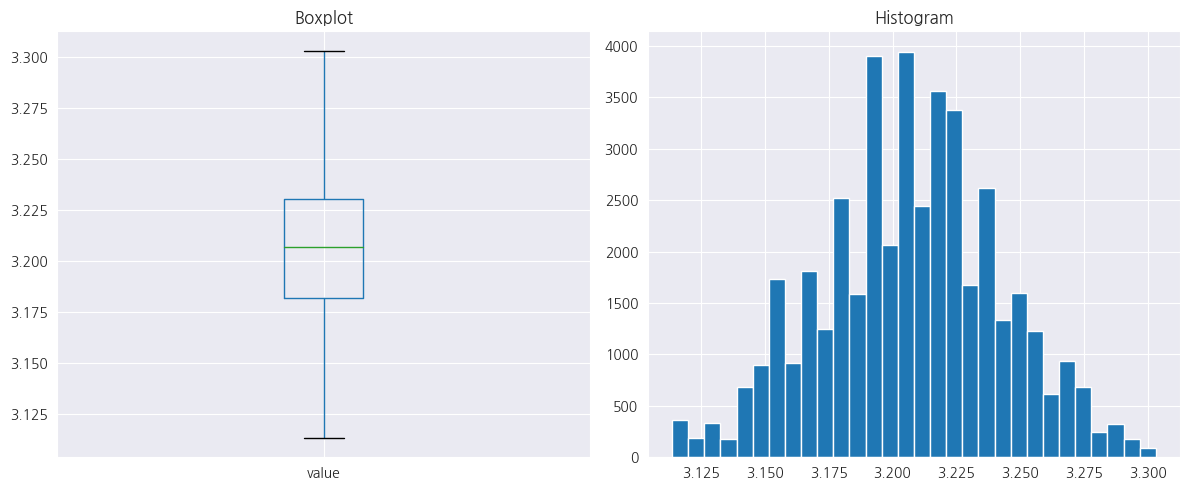

In [234]:
# 이상치 제거 함수 (IQR 사용)
def remove_outliers_by_iqr(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

# 각 데이터 세트에 IQR 이상치 제거 적용
power_cleand_df = remove_outliers_by_iqr(power_df, 'value')
temperature_cleand_df = remove_outliers_by_iqr(temperature_df, 'value')

# 시간 기간별로 그룹화하고 각 시간 기간에 대한 평균 전력 사용량 계산
power_avg = power_cleand_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

# 시간 기간별로 그룹화하고 각 시간 기간에 대한 평균 온도 계산
temp_avg = temperature_cleand_df.groupby('time').value.mean().reset_index(name='avg_temperature')

# 시간대(time_hour_min)를 기준으로 두 데이터 프레임 결합
combined_data = pd.merge(power_avg, temp_avg, on='time')

# 상관 관계 계산
correlation = combined_data[['avg_power_usage', 'avg_temperature']].corr()

# 상관계수 출력
print("온도와 전력 사용 사이의 상관계수는 다음과 같습니다:")
print(correlation)
load_and_visualize_data(power_cleand_df)
load_and_visualize_data(temperature_cleand_df)

### Z-점수를 사용하여 이상치를 제거한 결과

온도와 전력 사용 사이의 상관계수는 다음과 같습니다:
                 avg_power_usage  avg_temperature
avg_power_usage         1.000000         0.542423
avg_temperature         0.542423         1.000000


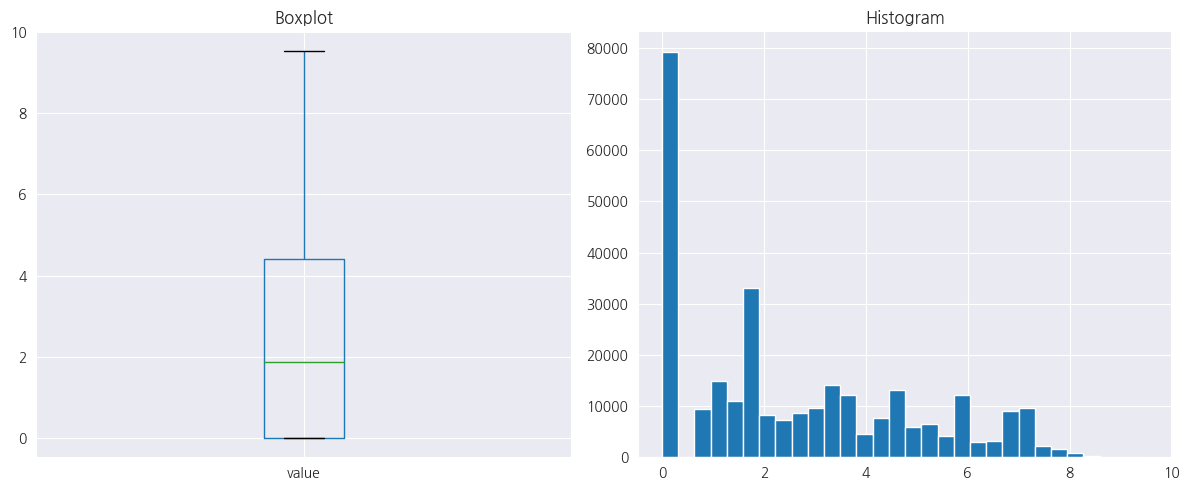

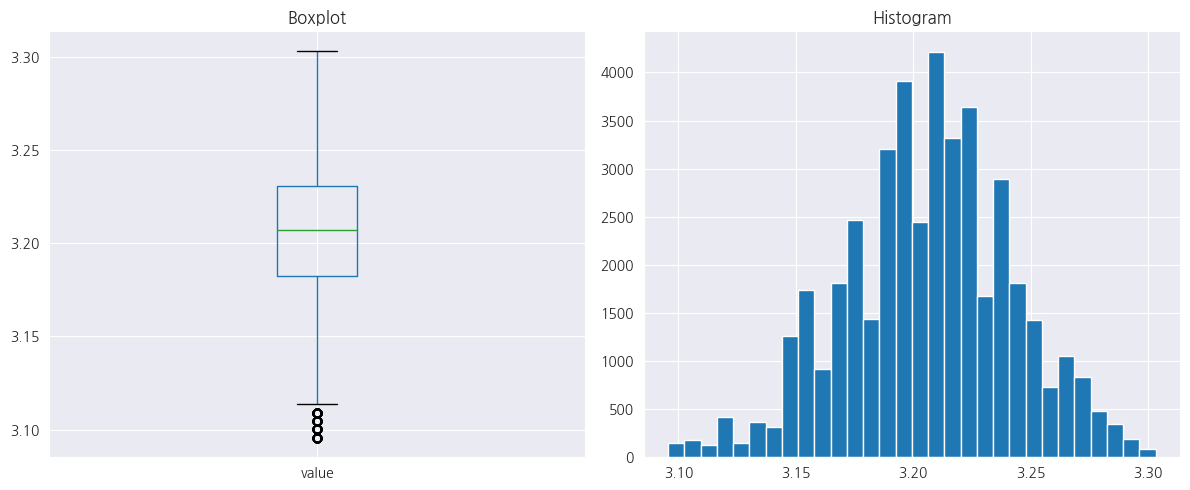

In [241]:
# 이상치 제거 함수 (z-점수 사용)
def remove_outliers_by_zscore(df, column_name, z_thresh):
    df['z_score'] = zscore(df[column_name])
    return df[np.abs(df['z_score']) <= z_thresh].drop(columns=['z_score'])

# 각 데이터 세트에 z-score 이상치 제거 적용
power_cleand_df = remove_outliers_by_zscore(power_df, 'value', 3)
temperature_cleand_df = remove_outliers_by_zscore(temperature_df, 'value', 3)

# 시간 기간별로 그룹화하고 각 시간 기간에 대한 평균 전력 사용량 계산
power_avg = power_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

# 시간 기간별로 그룹화하고 각 시간 기간에 대한 평균 온도 계산
temp_avg = temperature_df.groupby('time').value.mean().reset_index(name='avg_temperature')

# 시간대(time_hour_min)를 기준으로 두 데이터 프레임 결합
combined_data = pd.merge(power_avg, temp_avg, on='time')

# 상관 관계 계산
correlation = combined_data[['avg_power_usage', 'avg_temperature']].corr()

# 상관계수 출력
print("온도와 전력 사용 사이의 상관계수는 다음과 같습니다:")
print(correlation)
load_and_visualize_data(power_cleand_df)
load_and_visualize_data(temperature_cleand_df)

### 이상치 제거 결과
앞서 이상치를 X-점수나 IQR를 사용하여 이상치를 제거하였을때  

### Isolation Forest를 이용한 이상치 제거

                       time     value    place                 location  \
0       2024-04-15 00:02:00  3.198673  class_a           ac_indoor_unit   
1       2024-04-15 00:02:00  4.731803  class_a          ac_outdoor_unit   
2       2024-04-15 00:02:00  2.197225  class_a           automatic_door   
3       2024-04-15 00:02:00  0.000000  class_a  outdoor_unit_room_light   
4       2024-04-15 00:04:00  3.198673  class_a           ac_indoor_unit   
...                     ...       ...      ...                      ...   
291211  2024-04-30 00:00:00  1.386294   office          pair_rm_heating   
291212  2024-04-30 00:00:00  5.933571   office           server_heating   
291213  2024-04-30 00:00:00  0.000000   office               sign_power   
291214  2024-04-30 00:00:00  0.000000   office                       sp   
291215  2024-04-30 00:00:00  4.595120   office   water_purifier_heating   

          scores  anomaly  
0       0.189296        1  
1       0.182233        1  
2       0.15553

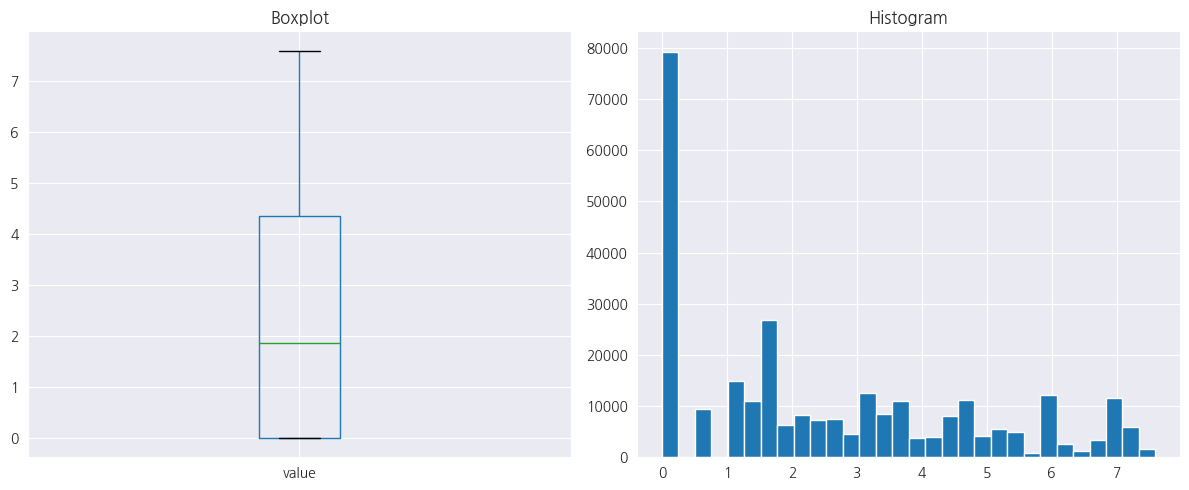

In [252]:
from sklearn.ensemble import IsolationForest

# Isolation Forest 모델 생성 및 훈련
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.01), random_state=42)
clf.fit(power_df[['value']])

# 이상치 점수 계산 및 이상치 플래그
power_df['scores'] = clf.decision_function(power_df[['value']])
power_df['anomaly'] = clf.predict(power_df[['value']])

# 이상치 데이터 제거
cleaned_data = power_df[power_df['anomaly'] == 1]
print(cleaned_data)
load_and_visualize_data(cleaned_data)

## 이상치 제거를 위한 최적의 Z-점수 파라미터 분석 
히트맵을 활용하여 다양한 Z-점수 임계값이 온도와 전력 사용량 간의 상관 관계 수치를 시각화했습니다.

이를 통해 최적의 이상치 제거 임계값을 찾는 작업을 진행했습니다.

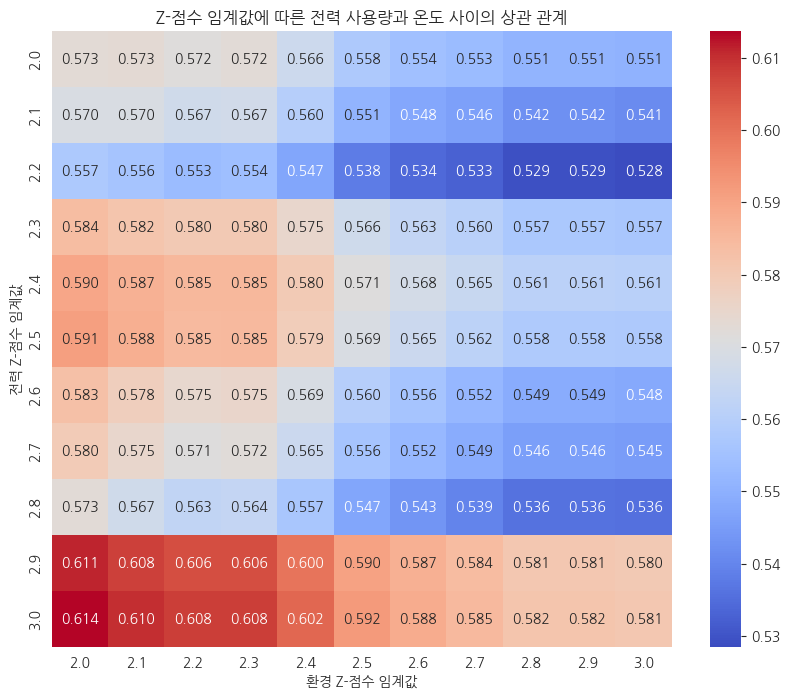

In [148]:
# 각 데이터 세트에 대한 Z-점수 임계값 범위 지정
z_thresh_range_power = np.linspace(2.0, 3.0, 11)
z_thresh_range_env = np.linspace(2.0, 3.0, 11)

# 상관관계를 저장할 딕셔너리
correlation_results = {}

# 모든 조합의 z-점수 임계값에 대해 반복
for z_power in z_thresh_range_power:
    for z_env in z_thresh_range_env:
        # 이상치 제거
        temp_filtered_df = remove_outliers_by_zscore(temperature_df, 'value', z_env)
        power_filtered_df = remove_outliers_by_zscore(power_df, 'value', z_power)

        # 시간별 그룹으로 평균값 계산
        temp_avg = temp_filtered_df.groupby('time').value.mean().reset_index(name='avg_temperature')
        power_avg = power_filtered_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

        # 데이터 프레임을 시간 기준으로 결합
        combined_data = pd.merge(temp_avg, power_avg, on='time')

        # 상관관계 계산
        correlation = combined_data[['avg_temperature', 'avg_power_usage']].corr().iloc[0, 1]
        correlation_results[(z_power, z_env)] = correlation

# 히트맵 데이터를 배열로 변환
correlation_matrix = np.array([[correlation_results[(z_power, z_env)] for z_env in z_thresh_range_env] for z_power in z_thresh_range_power])

# 히트맵 생성
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f",
            xticklabels=np.round(z_thresh_range_env, 1),
            yticklabels=np.round(z_thresh_range_power, 1))

plt.title('Z-점수 임계값에 따른 전력 사용량과 온도 사이의 상관 관계')
plt.xlabel('환경 Z-점수 임계값')
plt.ylabel('전력 Z-점수 임계값')
plt.show()

In [149]:
# 가장 높은 상관관계 점수 찾기
max_correlation_value = max(correlation_results.values())

# 해당 상관관계 점수에 해당하는 z-점수 임계값 찾기
max_correlation_thresholds = [thresholds for thresholds, correlation in correlation_results.items() if correlation == max_correlation_value]

# 결과 출력
print(f"최대 상관관계 점수: {max_correlation_value * 100:.2f}%")
print(f"해당 점수를 가진 Z-점수 임계값 조합: {max_correlation_thresholds}")

최대 상관관계 점수: 61.37%
해당 점수를 가진 Z-점수 임계값 조합: [(3.0, 2.0)]


## 이상치 제거 전후 시각화

In [150]:
power_original = power_df.groupby('time').value.mean().reset_index(name='avg_power_usage')
temperature_original = temperature_df.groupby('time').value.mean().reset_index(name='avg_temperature')

temperature_cleand_df = remove_outliers_by_zscore(temperature_df, 'value', 2.0)
power_cleand_df = remove_outliers_by_zscore(power_df, 'value', 2.1)

temp_avg = temperature_cleand_df.groupby('time').value.mean().reset_index(name='avg_temperature')
power_avg = power_cleand_df.groupby('time').value.mean().reset_index(name='avg_power_usage')

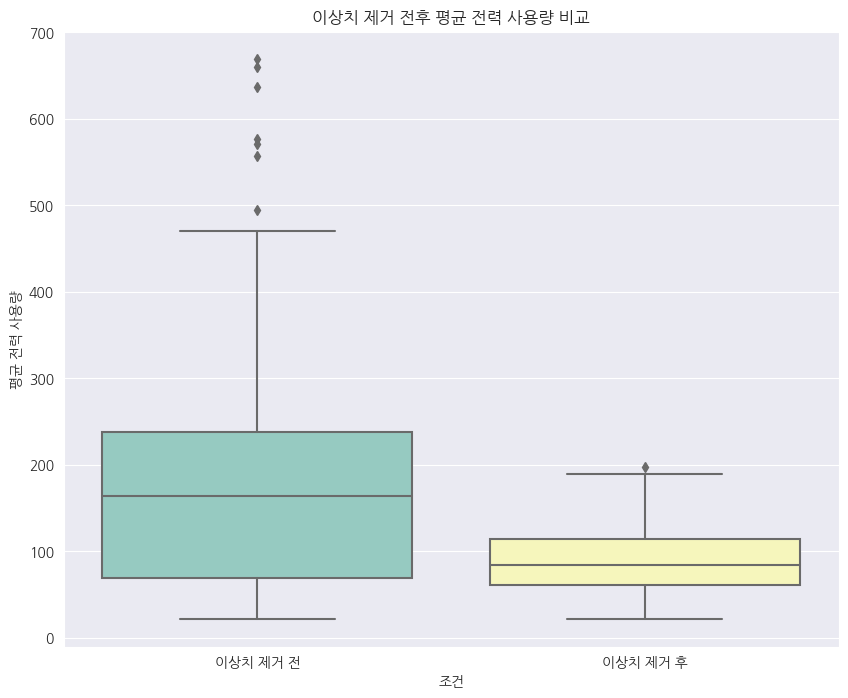

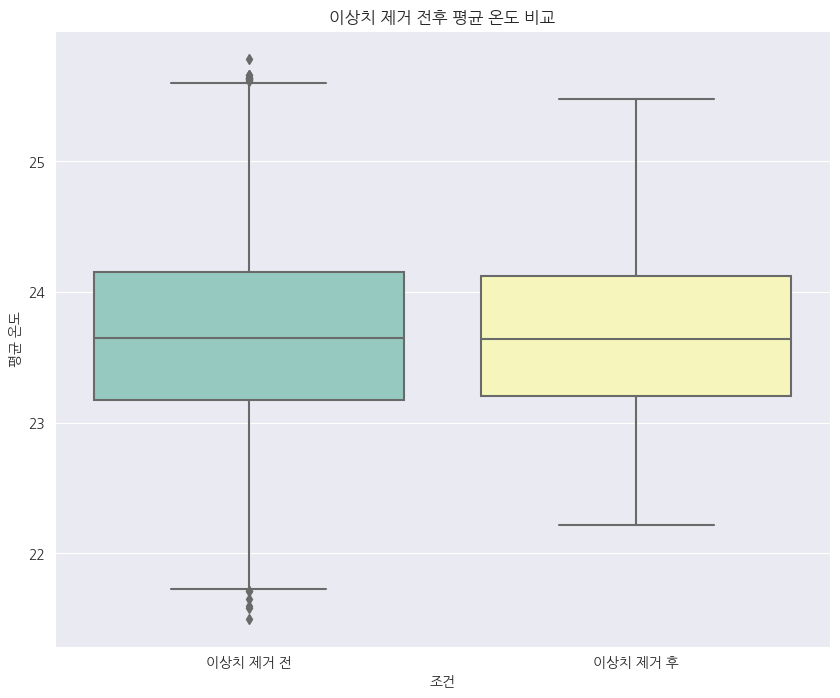

In [151]:
# 데이터에 'Condition' 레이블 추가하기
power_original['Condition'] = '이상치 제거 전'
power_avg['Condition'] = '이상치 제거 후'

# 두 데이터프레임을 하나로 합치기
combined_data = pd.concat([power_original, power_avg])

# 박스 플롯 생성
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
sns.boxplot(data=combined_data, y='avg_power_usage', x='Condition', palette="Set3")

# 그래프 제목 및 레이블 설정
plt.title('이상치 제거 전후 평균 전력 사용량 비교')
plt.xlabel('조건')
plt.ylabel('평균 전력 사용량')

temperature_original['Condition'] = '이상치 제거 전'
temp_avg['Condition'] = '이상치 제거 후'

# 두 데이터프레임을 하나로 합치기
combined_data = pd.concat([temperature_original, temp_avg])

# 박스 플롯 생성
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
sns.boxplot(data=combined_data, y='avg_temperature', x='Condition', palette="Set3")

# 그래프 제목 및 레이블 설정
plt.title('이상치 제거 전후 평균 온도 비교')
plt.xlabel('조건')
plt.ylabel('평균 온도')

# 그래프 표시
plt.show()

## 가설 기반 데이터 추가 분석
가설: 전력 데이터에서 온도 변화에 영향을 주는 장비가 존재할 것이다.

해당 가설을 기반으로 주가 전처리 후 장비별로 온도변화에 어떠한 영향을 주는지 분석

### 데이터 분리
정밀한 데이터 분석을 위해 장소별 데이터를 분리 및 시간별 집계

In [152]:
# 온도 데이터를 불러오고 'time' 열을 datetime 타입으로 변환합니다.
temperature_cleand_df['time'] = pd.to_datetime(temperature_cleand_df['time'])

# 장소(place)별로 그룹화하고, 각 그룹을 'time' 기준으로 시간별(Hourly)로 평균을 내기 위해 resample을 사용합니다.
temperature_hourly_avg = temperature_cleand_df.groupby('place').resample('H', on='time').mean().reset_index()

# 결과를 확인하기 위해 처음 몇 줄을 출력합니다.
print(temperature_hourly_avg)

       place                time      value
0    class_a 2024-04-15 00:00:00  23.702730
1    class_a 2024-04-15 01:00:00  23.897339
2    class_a 2024-04-15 02:00:00  24.035556
3    class_a 2024-04-15 03:00:00  24.310084
4    class_a 2024-04-15 04:00:00  24.660364
..       ...                 ...        ...
717   office 2024-04-29 20:00:00  23.275000
718   office 2024-04-29 21:00:00  23.236667
719   office 2024-04-29 22:00:00  23.280000
720   office 2024-04-29 23:00:00  23.503448
721   office 2024-04-30 00:00:00  23.600000

[722 rows x 3 columns]


In [153]:
# 전력 데이터를 불러오고 'time' 열을 datetime 타입으로 변환합니다.
power_cleand_df['time'] = pd.to_datetime(power_cleand_df['time'])

# 장소(place)별, 장치(location)별로 그룹화하고, 각 그룹을 'time' 기준으로 시간별(Hourly)로 평균을 내기 위해 resample을 사용합니다.
power_hourly_avg = power_cleand_df.groupby(['place', 'location']).resample('H', on='time').mean().reset_index()

# 결과를 확인하기 위해 처음 몇 줄을 출력합니다.
print(power_hourly_avg)

        place                location                time       value
0     class_a          ac_indoor_unit 2024-04-15 00:00:00   24.758621
1     class_a          ac_indoor_unit 2024-04-15 01:00:00   23.683333
2     class_a          ac_indoor_unit 2024-04-15 02:00:00   23.633333
3     class_a          ac_indoor_unit 2024-04-15 03:00:00   24.766667
4     class_a          ac_indoor_unit 2024-04-15 04:00:00   24.466667
...       ...                     ...                 ...         ...
9731   office  water_purifier_heating 2024-04-29 20:00:00   60.466667
9732   office  water_purifier_heating 2024-04-29 21:00:00   30.516667
9733   office  water_purifier_heating 2024-04-29 22:00:00  126.433333
9734   office  water_purifier_heating 2024-04-29 23:00:00   36.600000
9735   office  water_purifier_heating 2024-04-30 00:00:00   98.000000

[9736 rows x 4 columns]


### 각 장치별 온도와의 연관 관계 분석

In [154]:
temperature_hourly_avg.rename(columns={'value': 'temp_value'}, inplace=True)
power_hourly_avg.rename(columns={'value': 'power_value'}, inplace=True)

# 'Class A' 장소에 대한 데이터를 'place'와 'time'을 기준으로 결합합니다.
merged_data_class_a = pd.merge(
    temperature_hourly_avg[temperature_hourly_avg['place'] == 'class_a'],
    power_hourly_avg[power_hourly_avg['place'] == 'class_a'],
    on=['place', 'time'],
    how='inner'
)

# 각 장치별로 온도와 전력 사용량 사이의 상관 계수를 계산합니다.
correlation_results_class_a = merged_data_class_a.groupby('location').apply(
    lambda df: df[['temp_value', 'power_value']].corr().iloc[0, 1]
)

# 결과를 출력합니다.
print(correlation_results_class_a.sort_values(ascending=False))

location
automatic_door             0.173128
ac_outdoor_unit           -0.166403
ac_indoor_unit            -0.281994
outdoor_unit_room_light         NaN
dtype: float64


In [155]:
# 'Office' 장소에 대한 데이터를 'place'와 'time'을 기준으로 결합합니다.
merged_data_office = pd.merge(
    temperature_hourly_avg[temperature_hourly_avg['place'] == 'office'],
    power_hourly_avg[power_hourly_avg['place'] == 'office'],
    on=['place', 'time'],
    how='inner'
)

# 각 장치별로 온도와 전력 사용량 사이의 상관 계수를 계산합니다.
correlation_results_office = merged_data_office.groupby('location').apply(
    lambda df: df[['temp_value', 'power_value']].corr().iloc[0, 1]
)

# 정렬된 결과를 출력합니다.
print(correlation_results_office.sort_values(ascending=False))

location
office_heating2            0.473773
class_a_floor_heating_1    0.473201
air_conditioner            0.458057
class_a_floor_heating_2    0.454223
a_project                  0.424549
server_heating             0.376960
b_project                  0.367396
hive_heating               0.302673
pair_rm_heating            0.301963
ac_indoor_unit             0.298184
meeting_rm_heating         0.289217
office_heating1            0.257062
water_purifier_heating     0.249061
ac_outdoor_unit            0.248779
ac                         0.207480
automatic_door             0.142022
office_copier              0.126126
sign_power                 0.098022
built_in_heating          -0.147397
barton_heating_window           NaN
office_heating3                 NaN
outdoor_unit_room_light         NaN
sp                              NaN
dtype: float64
